In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Transaction analysis

In this notebook we analyze the data set of all filtered dust-creating and dust-consuming transactions.

In [2]:
inputs = pd.read_csv('data/txs_filtered_inputs.csv')
outputs = pd.read_csv('data/txs_filtered_outputs.csv')
dustInputs = inputs[(inputs.amount >= 1) & (inputs.amount <= 545)]
dustOutputs = outputs[(outputs.amount >= 1) & (outputs.amount <= 545)]
nonDustInputs = inputs[inputs.amount > 545]
nonDustOutputs = outputs[outputs.amount > 545]

## Global analysis

We first count the number of dust-creating and dust-consuming transactions.

In [3]:
creatingIds = dustOutputs.txId.unique()
consumingIds = dustInputs.txId.unique()
bothIds = np.intersect1d(creatingIds, consumingIds, assume_unique=True)
print('Dust-creating TXs:\t{}\nDust-consuming TXs:\t{}\nBoth:\t\t\t{}'.format(
    len(creatingIds), len(consumingIds), len(bothIds)))

Dust-creating TXs:	194628
Dust-consuming TXs:	202448
Both:			9746


Then we compute the average number of dust outputs (resp. inputs) in dust-creating (resp. dust-consuming) transactions.

In [4]:
outInfo = pd.DataFrame({'numOut': outputs.txId.value_counts()}).reset_index(names=['txId'])
tmp = pd.DataFrame({'numDustOut': dustOutputs.txId.value_counts()}).reset_index(names=['txId'])
outInfo = outInfo.merge(tmp, how='left', on='txId').fillna(0).astype(int)
outInfo['percentage'] = outInfo['numDustOut']/outInfo['numOut']

inInfo = pd.DataFrame({'numIn': inputs.txId.value_counts()}).reset_index(names=['txId'])
tmp = pd.DataFrame({'numDustIn': dustInputs.txId.value_counts()}).reset_index(names=['txId'])
inInfo = inInfo.merge(tmp, how='left', on='txId').fillna(0).astype(int)
inInfo['percentage'] = inInfo['numDustIn']/inInfo['numIn']

avgNumDustOut = np.mean(outInfo[outInfo.numDustOut > 0].numDustOut)
avgNumDustIn = np.mean(inInfo[inInfo.numDustIn > 0].numDustIn)

avgDustOutPerc = np.mean(outInfo[outInfo.numDustOut > 0].percentage) * 100
avgDustInPerc = np.mean(inInfo[inInfo.numDustIn > 0].percentage) * 100

print('Avg. number of dust inputs:\t{}\nAvg. number of dust outputs:\t{}'.format(avgNumDustIn, avgNumDustOut))
print('Avg. perc. of dust inputs:\t{}\nAvg. perc. of dust outputs:\t{}'.format(avgDustInPerc, avgDustOutPerc))

Avg. number of dust inputs:	4.09755591559314
Avg. number of dust outputs:	14.708495180549562
Avg. perc. of dust inputs:	29.296245847788448
Avg. perc. of dust outputs:	51.574402791945126


We plot the distributions of dust outputs (resp. inputs) in dust-creating (resp. dust-consuming) transactions.

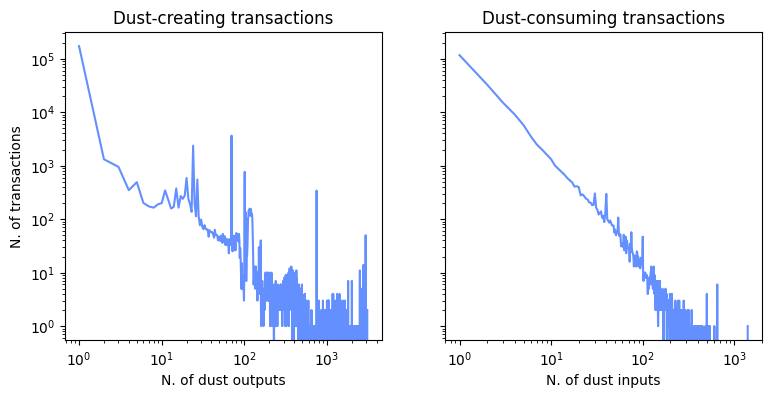

In [5]:
data_out = dustOutputs.groupby('txId').size().values
data_in = dustInputs.groupby('txId').size().values

hist_out, bins_out = np.histogram(data_out, bins=np.arange(1, np.max(data_out)+1))
hist_in, bins_in = np.histogram(data_in, bins=np.arange(1, np.max(data_in)+1))

fig = plt.figure(figsize=(9,4))

ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title('Dust-creating transactions')
ax1.set_xlabel('N. of dust outputs')
ax1.set_ylabel('N. of transactions')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.plot(bins_out[:-1], hist_out, color='#648fff')

ax2 = fig.add_subplot(1, 2, 2, sharey=ax1)
ax2.set_title('Dust-consuming transactions')
ax2.set_xlabel('N. of dust inputs')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.plot(bins_in[:-1], hist_in, color='#648fff')

plt.setp(ax2.get_yticklabels(), visible=False)
plt.savefig("pictures/reduced-global.pdf", format='pdf', bbox_inches='tight')
plt.show()

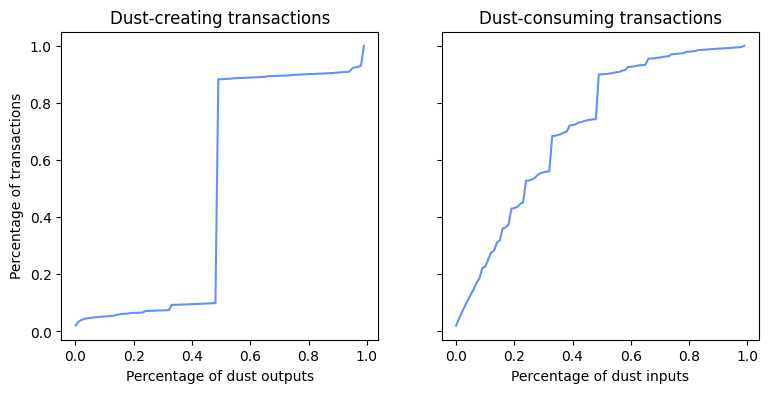

In [6]:
data_out = outInfo[outInfo.numDustOut > 0].percentage
data_in = inInfo[inInfo.numDustIn > 0].percentage

hist_out, bins_out = np.histogram(data_out, bins=100)
hist_in, bins_in = np.histogram(data_in, bins=100)

fig = plt.figure(figsize=(9,4))

ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title('Dust-creating transactions')
ax1.set_xlabel('Percentage of dust outputs')
ax1.set_ylabel('Percentage of transactions')
#ax1.set_xscale('log')
#ax1.set_yscale('log')
ax1.plot(bins_out[:-1], np.cumsum(hist_out)/np.sum(hist_out), color='#648fff')
#ax1.hist(data_out, bins=100, density=True, cumulative=-1, color='#648fff')

ax2 = fig.add_subplot(1, 2, 2, sharey=ax1)
ax2.set_title('Dust-consuming transactions')
ax2.set_xlabel('Percentage of dust inputs')
#ax2.set_xscale('log')
#ax2.set_yscale('log')
ax2.plot(bins_in[:-1], np.cumsum(hist_in)/np.sum(hist_in), color='#648fff')
#ax2.hist(data_in, bins=100, density=True, cumulative=-1, color='#648fff')

plt.setp(ax2.get_yticklabels(), visible=False)
#ax1.grid()
#ax1.minorticks_on()
#ax2.grid()
#ax2.minorticks_on()
plt.savefig('pictures/reduced-cumulative.pdf', format='pdf', bbox_inches='tight')
plt.show()

## Attack identification

In this section we try to identify transactions that are related to dust attacks. In particular, we would like to compute the following sets of transactions.

- **Suspect** dust-creating transactions: from the attacker's side, these transactions have the main goal of creating dust outputs.
- **Candidate** dust-consuming transactions: from the victim's side, these transactions are spending dust outputs from suspect transactions.

In [7]:
inclass = pd.read_csv('data/txs_filtered_inclass.csv')
outclass = pd.read_csv('data/txs_filtered_outclass.csv')
inclass['dustRatio'] = inclass['numDustIn'] / inclass['numIn']
outclass['dustRatio'] = outclass['numDustOut'] / outclass['numOut']
dustCreating = outclass[outclass.numDustOut > 0]
dustConsuming = inclass[inclass.numDustIn > 0]

### Suspect dust-creating transactions

These are transactions (potentially issued by attackers) whose main purpose is the creation of dust.

We first plot two heatmaps describing the number of dust-creating transactions as a function of the percentage of dust outputs over total outputs $j$ and the total number of dust outputs $k$. 

In each heatmap, the value of cell $(j, k)$ has the following meaning:

$$(j, k) = \text{number of dust-creating transactions with at least $j$% of dust outputs and at least $k$ dust outputs}$$

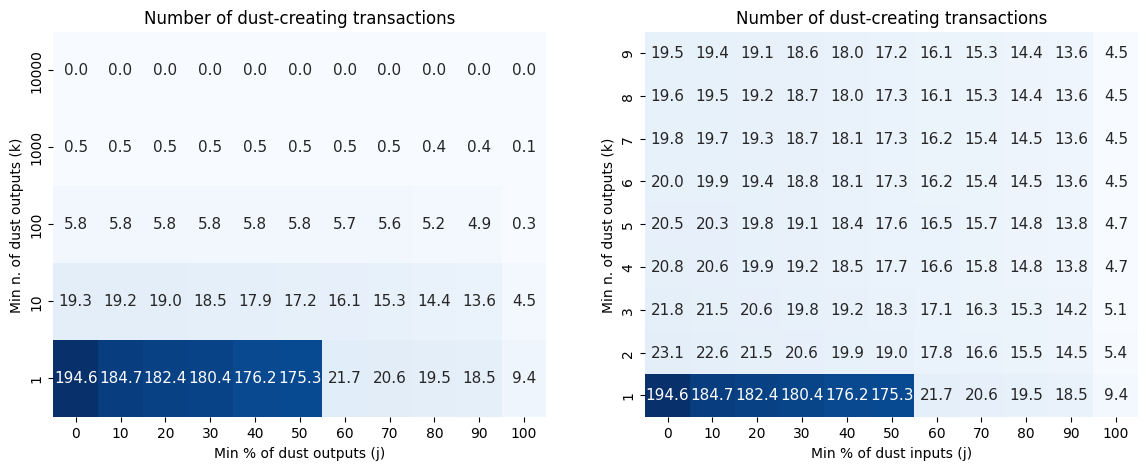

In [8]:
def numSuspectTxs(x, y):
    return (len(dustCreating[(dustCreating.dustRatio >= x) & (dustCreating.numDustOut >= y)]))
f = np.vectorize(numSuspectTxs)
xBins = np.arange(0, 1.1, 0.1, dtype=float)
xLabels = ['{:d}'.format(int(i*100)) for i in xBins]

fig = plt.figure(figsize=(14,5))

# Left
yBins1 = np.logspace(0, 4, num=5)
X1, Y1 = np.meshgrid(xBins, yBins1)
Z1 = f(X1, Y1) / 1e3
index1 = ['{:d}'.format(int(i)) for i in yBins1]
data1 = pd.DataFrame(Z1, columns=xLabels, index=index1)

ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title('Number of dust-creating transactions')
sns.heatmap(data1, cmap='Blues', annot=True, fmt='.1f', cbar=False, ax=ax1, annot_kws={"fontsize":11})
ax1.set_xlabel('Min % of dust outputs (j)')
ax1.set_ylabel('Min n. of dust outputs (k)')
ax1.invert_yaxis()

# Right
yBins2 = np.arange(1, 10, 1, dtype=int)
X2, Y2 = np.meshgrid(xBins, yBins2)
Z2 = f(X2, Y2) / 1e3
index2 = ['{:d}'.format(int(i)) for i in yBins2]
data2 = pd.DataFrame(Z2, columns=xLabels, index=index2)

ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title('Number of dust-creating transactions')
sns.heatmap(data2, cmap='Blues', annot=True, fmt='.1f', cbar=False, ax=ax2, annot_kws={"fontsize":11})
ax2.set_xlabel('Min % of dust inputs (j)')
ax2.set_ylabel('Min n. of dust outputs (k)')
ax2.invert_yaxis()

plt.savefig("pictures/reduced-heatmaps.pdf", format='pdf', bbox_inches='tight')

The set of suspect dust-creating transactions as the ones with $k \geq 2$ dust outputs and a percentage of dust outputs $j > 50\%$.

We count their number and save their identifiers to a file.

In [10]:
j = 0.5
k = 2
suspectTxs = dustCreating[(dustCreating.dustRatio > j) & (dustCreating.numDustOut >= k)].txId.values
np.savetxt('data/txs_suspect_ids.csv', sorted(suspectTxs), fmt='%d', delimiter='\n')
len(suspectTxs)

18840

### Candidate dust-consuming transactions

We classified dust-consuming transactions according to their **inputs**.

   - Type 1: there is only one unique input address.
   - Type 2+: there are at least two distinct input addresses.
   - Type S: special TXs (sum of all input amounts = fee).
   
Indeed, if we consider the *inputs* of a transaction:

- Type 1 may indicate an *unsuccessful* dust attack (only one address is used and nothing else is revealed about the spending entity).
- Type 2 may indicate a *successful* dust attack (multiple addresses are used and they might belong to the same entity).

In [11]:
tmp = dustConsuming.txType.value_counts()
df = pd.DataFrame({'TXs' : tmp, 'Percentage' : (tmp * 100)/ len(dustConsuming)}).round(3)
print('Total: {} transactions'.format(np.sum(df.TXs)))
df

Total: 202448 transactions


,TXs,Percentage
2+,116150,57.373
1,86284,42.620
S,14,0.007


We also save the set of type 2+ transaction identifiers to a text file.

In [12]:
twoPlusTxs = dustConsuming[dustConsuming.txType == '2+'].txId.unique()
np.savetxt('data/txs_twoplus_ids.csv', sorted(twoPlusTxs), fmt='%d', delimiter='\n')

At this point, we identify the set of _candidate_ dust-consuming transactions.

We define this set as the set of all 2+ dust-consuming transactions that are spending at least one output from a suspect dust-creating transaction. 

We count their number and save their identifiers to a file.

In [14]:
candidateTxs = inputs[(inputs.amount >= 1) & (inputs.amount <= 545) 
                      & (inputs.txId.isin(twoPlusTxs)) 
                      & (inputs.prevTxId.isin(suspectTxs))].txId.unique()
np.savetxt('data/txs_candidate_ids.csv', sorted(candidateTxs), fmt='%d', delimiter='\n')
len(candidateTxs)

89102